**Functions used throughout**

In [1]:
%matplotlib inline
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os, re, glob
from scipy import stats



In [ ]:
def compute_power(arr):  
    # used to compute power of signal and Power of Noise
    return sum([ np.abs(i)**2 for i in arr])/len(arr)


def plot_snr_density( noise_power, noiseless_signal_power, ax=None,title="title", xlabel="", ylabel=""):
    if ax is None:
        ax = plt.gca()    
    computed_snr = [10*np.log10(s/n) for s,n in zip(np.array(noiseless_signal_power),np.array(noise_power))]
   
    snr_density = stats.kde.gaussian_kde( computed_snr)   
    print("Some computed SNR values: ",computed_snr[1:5])
    x = np.arange(1.2*min(computed_snr), 1.2*max(computed_snr), 1e-3)
    ax.plot(x, snr_density(x))
    ax.set_title(title)
    #ax.set_xlim([1.2*min(x),1.2*max(x)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.locator_params(nbins=4)
    
def plot_density(noise_power, noisy_signal_power, ax=None, title="title", xlabel="", ylabel=""):
    if ax is None:
        ax = plt.gca()
    signal_power_density = stats.kde.gaussian_kde( np.array(noisy_signal_power) )
    noise_power_density = stats.kde.gaussian_kde( np.array(noise_power) )

    #x = np.arange(0, 1.2*max( noise_power), 1e-3)
    x = np.arange(min(sum([noisy_signal_power, noise_power],[0])), 1.2*max(sum([noisy_signal_power, noise_power],[0])), 1e-3)

    ax.plot(x, signal_power_density(x))
    ax.plot(x, noise_power_density(x), color='r')
    ax.set_title(title)
    #ax.set_xlim([1.2*min(x),1.2*max(x)])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(['noisy signal pwr','noise pwr'],  loc="best")
    ax.locator_params(nbins=4)

def plot_avg_pwr(noise_power, noisy_signal_power, ax=None,  title="title",  xlabel="", ylabel=""):
        # Title feature not working    
        # plot avg power for noisy signal and nosie for pickled files of a specified db
        ax.scatter(noisy_signal_power,range(len(noisy_signal_power)), alpha=0.2)
        ax.scatter(noise_power,range(len(noise_power)), color="r", alpha=0.2)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.legend(['noisy signal pwr','noise pwr'],  loc="best")
        ax.set_title(title)
        ax.set_xlim([0,max(noisy_signal_power)])
        ax.set_ylim([0,max(range(len(noisy_signal_power)))])
        ax.locator_params(nbins=4)
        
def compute_M2(sample, i): 
    return np.mean(abs(sample[i])**2)

def compute_M4(sample, i): 
    return np.mean(abs(sample[i])**4)

# Collect shape function data for no_data file for each SNR
def shape_fn(func, no_data=no_data ):
    # arrays will be appened with data as we iterate through snrs in snrlist
    shapeFn_noise = []
    shapeFn_noise_err= []
    shapeFn_sn= []
    shapeFn_sn_err= []
    shapeFn_signal= []
    shapeFn_signal_err= []
   
    # shape function which will be plotted against SNR
    compute_shape = func
    
    for i, snr_desired in enumerate(snrlist):        

        noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_" + str(no_data) + "*noise.npy"
        noise_files= [file for file in glob.glob(noise_pattern)]
        noise_samples = np.array([j for f in noise_files  for i,j, in enumerate(np.load(f))]) #128xno_data, per srn only file w/ no_data samples is used
    
        signal_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_" + str(no_data) + "*signal.npy"
        signal_files = [file for file in glob.glob(signal_pattern)]
        signal_samples = np.array([j for f in signal_files for i,j, in enumerate(np.load(f))])

        sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_" + str(no_data) + "*sn.npy"
        sn_files = [file for file in glob.glob(sn_pattern)]
        sn_samples = np.array([j for f in sn_files for i,j, in enumerate(np.load(f))])
        
        # append mean M2_for_trials per SNR into array, for instance
        shapeFn_noise.append(np.mean([ compute_shape(noise_samples,j) for j in range(no_trials)]))   
        # M2_for_trials, for instance, for use in error bar
        nx2 = [compute_shape(noise_samples,j) for j in range(no_trials)]
        # limits of 95% confid for each snr
        shapeFn_noise_err.append(stats.t.interval(0.95, len(nx2)-1, loc=np.mean(nx2), scale=stats.sem(nx2)))

        # Noisy signal  
        shapeFn_sn.append(np.mean([compute_shape(sn_samples,j) for j in range(no_trials)]))
        sx2 = [compute_shape(sn_samples,j) for j in range(no_trials)]
        shapeFn_sn_err.append(stats.t.interval(0.95, len(sx2)-1, loc=np.mean(sx2), scale=stats.sem(sx2)))
    
        # NoiseLESS Signal
        shapeFn_signal.append(np.mean([ compute_shape(signal_samples,j) for j in range(no_trials)]))
        s2 = [ compute_shape(signal_samples,j) for j in range(no_trials)]
        shapeFn_signal_err.append(stats.t.interval(0.95, len(s2)-1, loc=np.mean(s2), scale=stats.sem(s2)))

    return [shapeFn_signal, shapeFn_signal_err, shapeFn_noise, shapeFn_noise_err, shapeFn_sn, shapeFn_sn_err ]
   
def plot_shape_fn(func, no_data=no_data, plot=None, shapeFn_name="", color_="b"):
        if (func is compute_k_w or func is compute_k_a or func is compute_Esnr_m2m4_cx or func is compute_Esnr_m2m4_rl):
            shapeFn_data = func( no_data)
            plot.plot( snrlist, shapeFn_data,alpha=0.9, label=shapeFn_name, color=color_ )
            plot.set_ylim([min(sum(  [0], shapeFn_data )),max( shapeFn_data)])
        
        else:
            shapeFn_signal, shapeFn_signal_err, shapeFn_noise, shapeFn_noise_err, shapeFn_sn, shapeFn_sn_err = \
               shape_fn(func,no_data) 
        
            plot.plot( snrlist, shapeFn_sn,color="b",alpha=0.9, label=shapeFn_name + "_sn")
            plot.plot( snrlist, shapeFn_noise,color="r",alpha=0.9, label= shapeFn_name + "_noise")
            plot.scatter( snrlist, shapeFn_signal  ,color="g",alpha=0.9, label= shapeFn_name +"_signal")
            plot.set_ylim([min( sum([[0],shapeFn_sn,shapeFn_noise, shapeFn_signal],[]) ),1.1*max( sum([shapeFn_sn,shapeFn_noise, shapeFn_signal],[]) )])

            # compute error deltas
            yerr_noise = [(a-b) for (a,b) in shapeFn_noise_err]
            print(yerr_noise)
            # ie errobar(x,y,yerr=error deltas for each value of y)
            plot.errorbar(snrlist, shapeFn_noise, yerr=yerr_noise,  color="black")
 
            yerr_sn = [(a-b) for (a,b) in shapeFn_sn_err]
            plot.errorbar(snrlist, shapeFn_sn, yerr=yerr_sn, color="black")

            yerr_signal = [(a-b) for (a,b) in shapeFn_signal_err]
            plot.errorbar(snrlist, shapeFn_signal, yerr=yerr_signal , color="black")
 
        plot.set_xticks(snrlist)
        plot.legend( loc="best")
    

def compute_k_a(no_data=no_data ):
    M2 = shape_fn(compute_M2,no_data) 
    M4 = shape_fn(compute_M4,no_data) 
    return  np.array(M4[0])/(np.array(M2[0])**2)

def compute_k_w(no_data=no_data):
    M2 = shape_fn(compute_M2,no_data) 
    M4 = shape_fn(compute_M4,no_data) 
    return  np.array(M4[2])/(np.array(M2[2])**2)

def compute_Esnr_m2m4_cx(no_data=no_data):
    M2 = shape_fn(compute_M2,no_data) 
    M4 = shape_fn(compute_M4,no_data) 
    M2= np.array(M2[4])
    M4= np.array(M4[4])
    num = np.sqrt(2*M2**2 - M4)
    return num/ (M4-num)

def compute_Esnr_m2m4_rl(no_data=no_data):
    M2 = shape_fn(compute_M2,no_data)
    M4 = shape_fn(compute_M4,no_data) 
    M2= np.array(M2[4])
    M4= np.array(M4[4])
    num = .5 * np.sqrt(6*M2**2 - 2*M4)
    return num/ (M4-num)

# Finding Alternative Features on which to classify
*Immediate TODO*
     * "point out what these tell us about M2 and M4" -- FF



## M2,M4, k_a,k_w, estimatedSNR_M2M4 formulas 
** What is the expected value of the 2nd moment of the M-PSK signal? of the noise? Go through the derivation in the paper, explain.**

*      **ANS:** The variance for the AWGN should be unit variance, since the noise is Gaussian. The expected value of moments can be approximated in the equations given above, which are lifted from the IEEE A *Comparison of SNR Estimation Techniques for the AWGN Channel* paper


* <span style="background-color: #0FFF0F">**ISSUE**:  I'm still trying to figure out what variance I should expect for M-ary PSK signal.</span>

** What is the expected value of the 4th moment of the M-PSK signal? of the noise? Go through the derivation in the paper, explain.**
* <span style="background-color: #0FFF00">**ISSUE**:  Also trying to figure out what the fourth moment should be for AWGN, and M-ary PSK .</span>
   

** Intuition behind 2nd, 4th moments **

The second moment $M_{2}$  is variance, or consistancy of the signal. 
$$M_{2}\approx \frac{1}{N_{sym}} \sum_{n=0}^{N_{sym}-1} \mid y_{n}\mid^2$$

The fourth moment $M_{4}$ is called kurtosis. It correlates to how peaked your graph is and measured against the normal distribution which has a kurtosis of 3.


$$M_{4}\approx \frac{1}{N_{sym}} \sum_{n=0}^{N_{sym}-1} \mid y_{n}\mid^4$$

$a_n$ is the sequence of M-ary source symbols.
$$a_n = e^{j \theta_{n}}$$

where $\theta_{n}$ <span style="background-color: #0FFF00">"is one of the M phases spaced evenly around the unit circle" </span>(IEEE paper) 
> So $\theta$ is just one of the four symbols, right?
 
$w_{n}$ is the symbol spaced filtered noise sample.

** $a_{n}$ is the signal (not including noise) and $w_{n}$ is the noise. **

The kurtosis of the signal, $k_{a}$. $$k_{a} =  \frac {\mathop{\mathbb{E}}( \mid a_{n}\mid ^{4}) } { ( \mathop{\mathbb{E}} \mid a_{n}\mid ^2 )^2 } $$


The kurtosis of noise, $k_{w}$. $$k_{w} =  \frac {\mathop{\mathbb{E}} (\mid w_{n}\mid ^{4} )} { ( \mathop{\mathbb{E}} \mid w_{n}\mid ^2 )^2 } $$

The predicted SNR by way of moment techniques includes a real and complex part. Moments are taken on the signal with noise.

$$\sigma_{M2M4,complex} = \frac { \sqrt{2M_{2}^2 - M_{4}}}{M_{2} - \sqrt{2M_{2}^2 - M_{4}}} $$



$$\sigma_{M2M4,real} = \frac { \frac{1}{2}\sqrt{6M_{2}^2 - 2M_{4}}}{M_{2} -  \frac{1}{2}\sqrt{6M_{2}^2 - 2M_{4}}} $$


 ** Repeat for 4th moment. You may find it helpful to *plot the distribution of the samples themselves (density plot) for the signal and noise, respectively, and point out what these tell us about M2 and M4.***

**Re: "Plot the Second and Fourth Moments for both the noise and signal for each SNR value", you might want to also include the signal without noise.**

**I don't know why we are combining samples from 128 trials here and computing their overall moments - we should be computing the moment 128 times, one for each trial.** -- FF

## Compute Moment based features vs SNR
### Computing the moment 128 times
Also include the signal without noise

*sn = signal + noise* 

<span style="background-color: #FFFF00">Error deltas for M4 have been omitted since they are very lage</span>

<span style="background-color: #FFFF00">**Observation (this is off have to update)**:  When we compute the moment 128 times, then find the mean moment for a given SNR, I observer the following. The signal has very little variance and a kurtosis of 0, which means that the signal has a normal distribution. The noise on the other hand has a variance that decreases with a higher SNR.</span>
* <span style="background-color: #0FFF00">**ISSUE**:  What unit for y-axis, ie what is the unit of the second moment -- is it dB^2...  is that a thing ?</span>

* <span style="background-color: #FFFF00"> What does the real and cx part of SNR mean? Anyways they seem off.</span>


In [15]:
snrlist = [-3,0,3,10] 

no_trials=128 
no_data=4096


[-9.8780698183593757e-07, -5.7240306087493961e-07, -2.8995443854742541e-07, -5.909112306759162e-08]
[-8.8433557481124287e-10, -2.6330936515442424e-10, -6.7632743988429072e-11, -2.5503675717261128e-12]
Cx computed SNR with M2M4: [-1.00174658 -1.00070969 -1.00035672 -1.00014643]
Rl computed SNR with M2M4: [-1.00076325 -1.00044548 -1.00027752 -1.00013834]


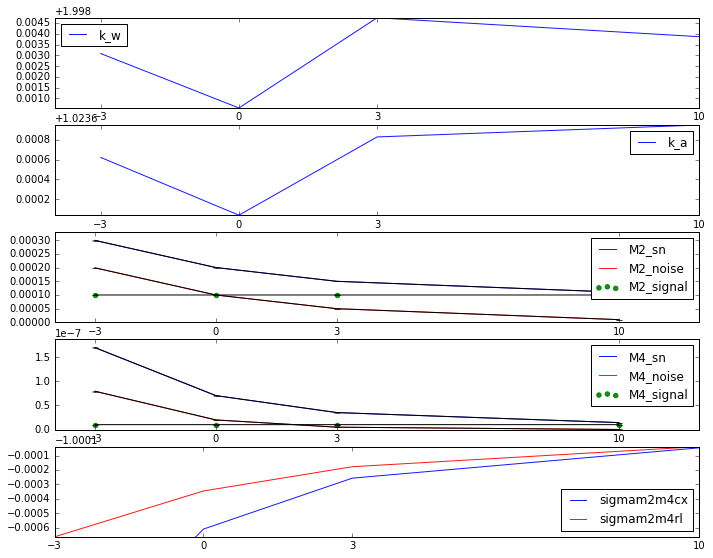

In [33]:
f3, axtuple3 = plt.subplots(5,1,  figsize=(10, 15)) # right only only  provide subplots for M2,M4, axtuple3[0], axtuple3[1]

#k_w =compute_k_w(no_data)
plot_shape_fn(compute_k_w, no_data,plot=axtuple3[0],shapeFn_name="k_w")
plot_shape_fn(compute_k_a, no_data,plot=axtuple3[1],shapeFn_name="k_a")


plot_shape_fn(compute_M2, no_data=no_data,plot=axtuple3[2], shapeFn_name="M2")
plot_shape_fn(compute_M4, no_data=no_data,plot=axtuple3[3], shapeFn_name="M4")

plt.tight_layout()
plt.subplots_adjust(bottom=0.5) # use a lower number to make more vertical space


print("Cx computed SNR with M2M4:",compute_Esnr_m2m4_cx(no_data=no_data))
print("Rl computed SNR with M2M4:",compute_Esnr_m2m4_rl(no_data=no_data))
plot_shape_fn(compute_Esnr_m2m4_cx, no_data,axtuple3[4],shapeFn_name="sigmam2m4cx")
plot_shape_fn(compute_Esnr_m2m4_rl, no_data,axtuple3[4],shapeFn_name="sigmam2m4rl", color_="r")

## plot the distribution of the samples themselves (density plot) for the signal and noise, respectively
<span style="background-color: #FFFF00"> Something went wrong generating this figures after I changed function code above; will come back and fix this"</span>


http://www.sciencedirect.com/science/article/pii/S1877705812018097
From paper above: "When the primary signal is absent, the decision statistic has a central chi square distribution with N degrees of freedom. When the primary signal is present, the decision statistic has a non-central chi square 
distribution with the same degrees of freedom [14]."

no of samples taken: 12800 out of 131072
no of samples taken: 12800 out of 131072
no of samples taken: 12800 out of 131072
no of samples taken: 12800 out of 131072


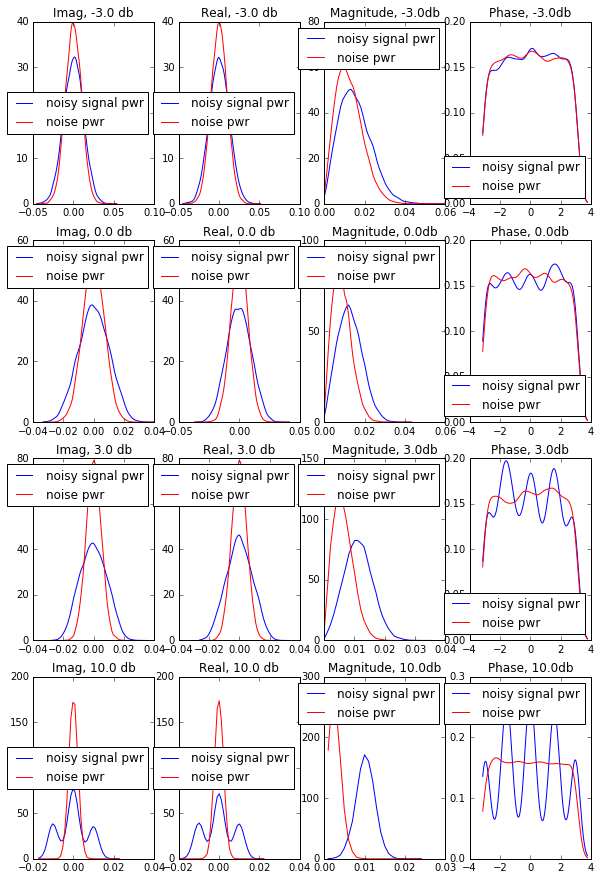

In [56]:
# plot distribution of flattened no_trials where ndata = 1024 for each value of SNR
# get this working: noise should have a central chi square distribution
#                   sn should have non central chi square distribution 

snrlist = [-3,0,3,10] 

f2, axtuple2 = plt.subplots(len(snrlist), 4, figsize=(10, 15))
no_trials=100 # when no_trials is  100, no of flattened samples is 12800


for ax_idx, snr_desired in enumerate(snrlist):        

    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*noise.npy"
    noise_files_1024 = [file for file in glob.glob(noise_pattern)]
    noise_samples_1024 = \
        np.ndarray.flatten(np.array([j for f in noise_files_1024 
                                     for i,j, in enumerate(np.load(f))])) [0:no_trials*128]
    
    
    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*sn.npy"
    sn_files_1024 = [file for file in glob.glob(sn_pattern)]
    sn_samples_1024 = \
        np.ndarray.flatten(np.array([j for f in sn_files_1024
                                     for i,j, in enumerate(np.load(f))])) [0:no_trials*128]
   
    #def plot_density(noise_power, noisy_signal_power, ax=None, title="title", xlabel="", ylabel=""):

    print("no of samples taken: %d out of 131072" % len(sn_samples_1024))


    # plot density of real part of no_trials worth of samples
    plot_density(np.real(noise_samples_1024), np.real(sn_samples_1024), axtuple2[ax_idx][1], title="Real, %.1f db" %snr_desired,xlabel="",ylabel="")
        
    # plot density of imag part of no_trials worth of samples
    plot_density(np.imag(noise_samples_1024), np.imag(sn_samples_1024), axtuple2[ax_idx][0], title="Imag, %.1f db" %snr_desired,xlabel="",ylabel="")
        
    # plot density of magnitude part of no_trials worth of samples
    plot_density(np.absolute(noise_samples_1024), np.absolute(sn_samples_1024), axtuple2[ax_idx][2], title="Magnitude, %.1fdb" %snr_desired,xlabel="",ylabel="")
        
    # plot density of phase part of no_trials worth of samples
    plot_density(np.angle(noise_samples_1024), np.angle(sn_samples_1024), axtuple2[ax_idx][3], title="Phase, %.1fdb" %snr_desired,xlabel="",ylabel="")
        

## SVM Classifer on samples
http://ieeexplore.ieee.org/document/6783871/

The above paper uses an SVM classifer to decide if signal samples are sn or noise. We will create two classifiers, one trained on just X, and the other on moment data to see if better predictions are made when the moments classifier is used.

**Load Data and divide into training and test set**


In [7]:
# get results per SNR, come back and loop later
# start at say SNR = 0; can't pool SNR's; train it per SNR
snrlist = [-3,0,3,10] 
no_trials=128 
no_data= 2048 # no_data not being evaluated here 

# sn_samples is all samples of sn at a given snr at a given no_data
snr_desired = 0
noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_" + str(no_data) +  "*noise.npy"
noise_files= [file for file in glob.glob(noise_pattern)]
noise_samples= \
        np.ndarray.flatten(np.array([j for f in noise_files for i,j, in enumerate(np.load(f))])) 

print((noise_samples)) ## 2048*128 entries

# noise_samples is all samples of noise at a given snr at a given no_data 
# Xtr is subset of sn_samples + noise_samples
# Ytr also produce


# with Xtr and Ytr , create SVC and just fit
# do accuracy infrastructure

#----
# do again, this time Xtr is moment data, M2 and M4

[ 0.00361496+0.00382091j  0.00263326+0.00293097j -0.00659106+0.00370014j
 ..., -0.00044141-0.00734554j -0.01419841+0.00298632j
 -0.00679859-0.00501742j]


## Example of Error bar useage

[-2.1796962782191028e-06, -1.036277505543252e-06, -5.4080874430744959e-07, -1.2060664023699866e-07]


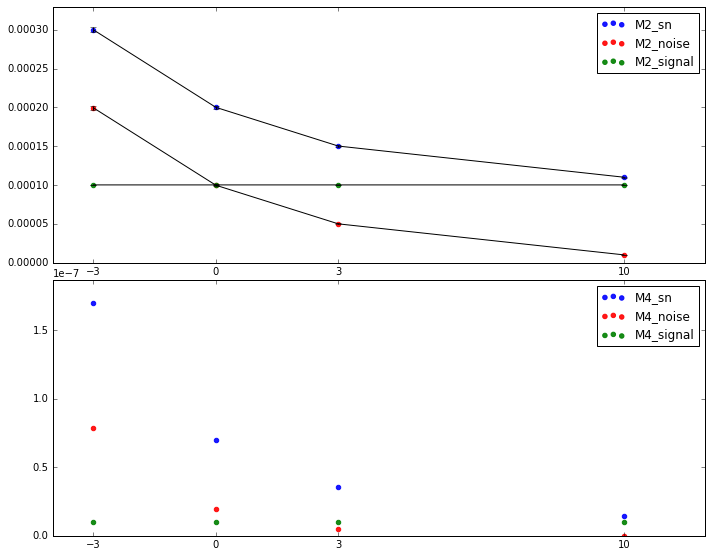

In [150]:
import scipy.stats as st
snrlist = [-3,0,3,10] 


f3, axtuple3 = plt.subplots(2,1,  figsize=(10, 15)) 
no_trials=128 # when no_trials is  100, no of flattened samples is 12800

M2_noise = []
M2_noise_err= []
M2_sn= []
M2_sn_err= []
M2_signal= []
M2_signal_err= []


M4_noise= []
M4_noise_err= []
M4_sn= []
M4_sn_err= []
M4_signal= []
M4_signal_err= []


# collect m2,m4 data for each snr, plot 95% confidence interval in error bar  limits
for i, snr_desired in enumerate(snrlist):        

# NEED TO COMPUTE M2 M4 for each trial
    ####128 trials of NOISE####
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*noise.npy"
    noise_files_1024 = [file for file in glob.glob(noise_pattern)]
    noise_samples_1024 = np.array([j for f in noise_files_1024  for i,j, in enumerate(np.load(f))]) #128x1024

    
    ####128 trials of NoiseLESS SIGNAL####
    signal_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*signal.npy"
    signal_files_1024 = [file for file in glob.glob(signal_pattern)]
    signal_samples_1024 = np.array([j for f in signal_files_1024 for i,j, in enumerate(np.load(f))])

    ####128 trials of Noisey SIGNAL####
    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*sn.npy"
    sn_files_1024 = [file for file in glob.glob(sn_pattern)]
    sn_samples_1024 = np.array([j for f in sn_files_1024 for i,j, in enumerate(np.load(f))])

    
#NOISE 
# append M2, M4, confidence limits for errors into arrays
    # Compute the moment 128 times, one for each trial. THEN finding mean of all the moments
    M2_noise.append(np.mean([np.mean(abs(noise_samples_1024[j])**2) for j in range(no_trials)]))   #becomes 4x128
    M4_noise.append(np.mean([np.mean(abs(noise_samples_1024[j])**4) for j in range(no_trials)])) 
            
    #limits of 95% confid
    nx2 = [np.mean(abs(noise_samples_1024[j])**2) for j in range(no_trials)]
    nx4 = [np.mean(abs(noise_samples_1024[j])**2) for j in range(no_trials)]

    M2_noise_err.append(st.t.interval(0.95, len(nx2)-1, loc=np.mean(nx2), scale=st.sem(nx2)))
    M4_noise_err.append(st.t.interval(0.95, len(nx4)-1, loc=np.mean(nx4), scale=st.sem(nx4)))

# Noisy signal  
    # append mean M2, M4 per SNR into arrays
    M2_sn.append(np.mean([np.mean(abs(sn_samples_1024[j])**2) for j in range(no_trials)]))
    M4_sn.append(np.mean([np.mean(abs(sn_samples_1024[j])**4) for j in range(no_trials)]))
   
    # mean moment data, used in error bar
    sx2 = [np.mean(abs(sn_samples_1024[j])**2) for j in range(no_trials)]
    sx4 = [np.mean(abs(sn_samples_1024[j])**4) for j in range(no_trials)]
    
    #limits of 95% confid
    M2_sn_err.append(st.t.interval(0.95, len(sx2)-1, loc=np.mean(sx2), scale=st.sem(sx2)))
    M4_sn_err.append(st.t.interval(0.95, len(sx4)-1, loc=np.mean(sx4), scale=st.sem(sx4)))
    
# NoiseLESS Signal
    # append mean M2, M4 per SNR into arrays
    M2_signal.append(np.mean([np.mean(abs(signal_samples_1024[j])**2) for j in range(no_trials)]))
    M4_signal.append(np.mean([np.mean(abs(signal_samples_1024[j])**4) for j in range(no_trials)]))
   
    # mean moment data, used in error bar
    s2 = [np.mean(abs(signal_samples_1024[j])**2) for j in range(no_trials)]
    s4 = [np.mean(abs(signal_samples_1024[j])**4) for j in range(no_trials)]
    
    #limits of 95% confid
    M2_signal_err.append(st.t.interval(0.95, len(s2)-1, loc=np.mean(s2), scale=st.sem(s2)))
    M4_signal_err.append(st.t.interval(0.95, len(s4)-1, loc=np.mean(s4), scale=st.sem(s4)))
    
        
### Plot M2 Data
# M2 data
axtuple3[0].scatter( snrlist, M2_sn,color="b",alpha=0.9, label="M2_sn")
axtuple3[0].scatter( snrlist, M2_noise,color="r",alpha=0.9, label="M2_noise")
axtuple3[0].scatter( snrlist, M2_signal  ,color="g",alpha=0.9, label="M2_signal")
axtuple3[0].set_ylim([min( sum([[0],M2_sn,M2_noise, M2_signal],[]) ),1.1*max( sum([M2_sn,M2_noise, M2_signal],[]) )])


# ie errobar(x,y,yerr=error deltas for each value of y)
# M2 error bar
yerr_noise = [(a-b) for (a,b) in M2_noise_err]
print(yerr_noise)
axtuple3[0].errorbar(snrlist, M2_noise, yerr=yerr_noise,  color="black")
 
yerr_sn = [(a-b) for (a,b) in M2_sn_err]
axtuple3[0].errorbar(snrlist, M2_sn, yerr=yerr_sn, color="black")

yerr_signal = [(a-b) for (a,b) in M2_signal_err]
axtuple3[0].errorbar(snrlist, M2_signal, yerr=yerr_signal , color="black")
 
axtuple3[0].set_xticks(snrlist)
axtuple3[0].legend( loc="best")


### Plot M4 Data
# M4 data
axtuple3[1].scatter( snrlist, M4_sn,color="b",alpha=0.9, label="M4_sn")
axtuple3[1].scatter( snrlist, M4_noise,color="r",alpha=0.9, label="M4_noise")
axtuple3[1].scatter( snrlist, M4_signal  ,color="g",alpha=0.9, label="M4_signal")

# M4 error bar
yerr_noise = [(a-b) for (a,b) in M4_noise_err]
#axtuple3[1].errorbar(snrlist, M4_noise, yerr=yerr_noise,  color="black")
 
yerr_sn = [(a-b) for (a,b) in M4_sn_err]
#axtuple3[1].errorbar(snrlist, M4_sn, yerr=yerr_sn, color="black")

yerr_signal = [(a-b) for (a,b) in M4_signal_err]
#axtuple3[1].errorbar(snrlist, M4_signal, yerr=yerr_noise, color="black")
 
axtuple3[1].set_xticks(snrlist)
axtuple3[1].legend( loc="best")
# ylim
axtuple3[1].set_ylim([min( sum([[0], M4_sn,M4_noise, M4_signal],[]) ), 1.1*max( sum([M4_sn,M4_noise, M4_signal],[]) )])


plt.tight_layout()
plt.subplots_adjust(bottom=0.5) # use a lower number to make more vertical space

(0, 5)

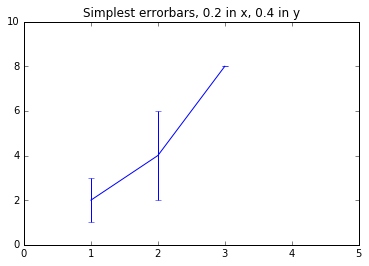

In [149]:
# example data
x = np.arange(1,4,1)
y = 2**x

# example variable error bar values
yerr = [1,2,0]

# First illustrate basic pyplot interface, using defaults where possible.
plt.figure()
plt.errorbar(x, y,  yerr=yerr)
plt.title("Simplest errorbars, 0.2 in x, 0.4 in y")
plt.ylim([0,10])
plt.xlim([0,5])


## Scatter Plot Of Average Power per SNR 

## The Density Plot of Average Power per SNR 

## Density Plot per SNR  

* <span style="background-color: #FFFF00">ISSUE: SNR value 3db off. I regenerated samples; need to investigate version of my gnuradio \* </span>

** Are the "noise" and "signal+noise" classes easily separable using "average received power" as the feature? **

* ANS: The two classes are not linearly seperable without misclassification. However, using a probalistic model  (either logistic regression or SVM)  should produce a model with a high accuracy. \*

* <span style="background-color: #FFFF00">ISSUE: Lost some density graphs; think because changed parameter in generating function; come back and fix thsi \* </span>


Some computed SNR values:  [-3.3058021039043997, -3.3044929227974915, -3.4094572590461953, -2.5469250396776468]
Some computed SNR values:  [-0.18194359603387628, -0.42181431749391129, 0.30509428030201202, 0.30554609884551653]
Some computed SNR values:  [2.6740597940769399, 2.6766705506788053, 2.8724179293083827, 1.8410740222426791]
Some computed SNR values:  [10.392609930784891, 9.5812204361779436, 9.5831242702735988, 10.169226463507457]


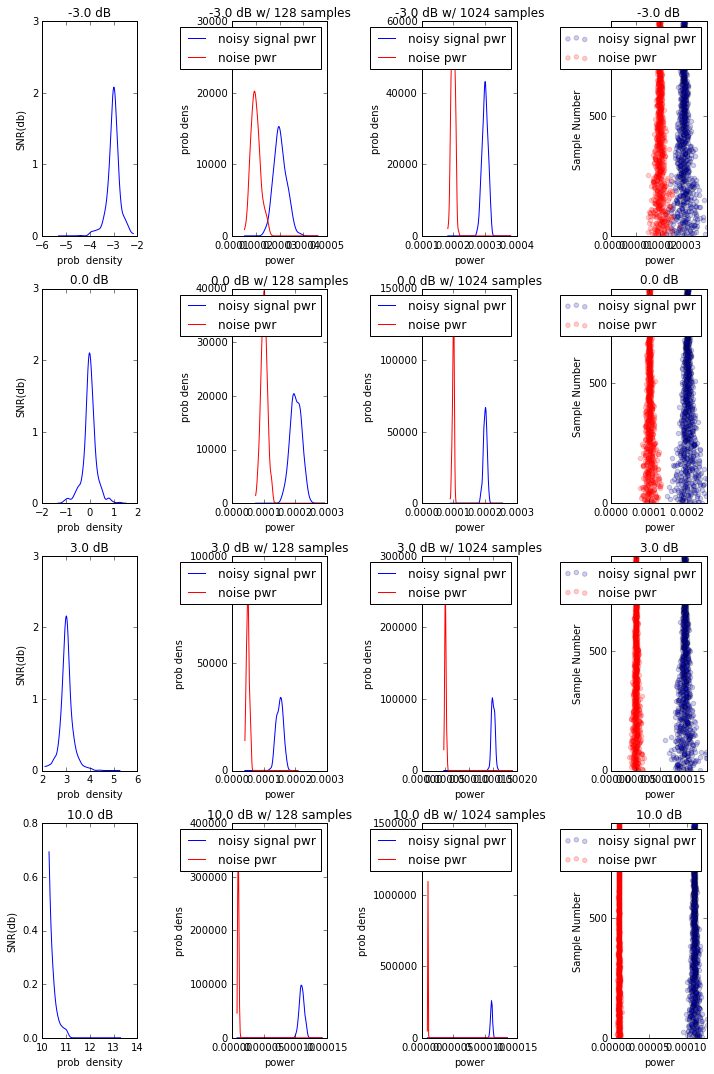

In [75]:
snrlist = [-3,0,3,10]
ndatalist = [64 , 128, 256, 512, 1024, 2048, 4096]
f, axtuple = plt.subplots(len(snrlist), 4, figsize=(10, 15))


for ax_idx, snr_desired in enumerate(snrlist):        

    # Get lists of sample files for the given SNR 
    noise_files = ["samples/samples_%.1fdb_%d_128_noise.npy" % (snr_desired, n) for n in ndatalist]
    signal_files = ["samples/samples_%.1fdb_%d_128_signal.npy" % (snr_desired, n) for n in ndatalist]
    sn_files = ["samples/samples_%.1fdb_%d_128_sn.npy" % (snr_desired, n) for n in ndatalist]
    
       
    # Compute power for each trial for trials in a file 
        # NESTED LOOP PATTERN: [len(WORD) for LINE in FILE for WORD in LINE]
    noise_power_array = [compute_power(j) for f in noise_files for i,j, in enumerate(np.load(f))]
    sn_power_array = [compute_power(j) for f in sn_files for i,j, in enumerate(np.load(f))]    
    signal_power_array = [compute_power(j) for f in signal_files for i,j, in enumerate(np.load(f))]    
    #print([x/y for x,y in zip(signal_power_array, noise_power_array)])
    
    # Read in data for experiments where we save just ndata=128 samples
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*noise.npy"
    noise_files_128 = [file for file in glob.glob(noise_pattern)]
    noise_power_128 = [compute_power(j) for f in noise_files_128 for i,j, in enumerate(np.load(f))]

    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_128" + "*sn.npy"
    sn_files_128 = [file for file in glob.glob(sn_pattern)]
    sn_power_128 = [compute_power(j) for f in sn_files_128 for i,j, in enumerate(np.load(f))]

    # Read in data for experiments where we save just ndata=1024 samples
    noise_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*noise.npy"
    noise_files_1024 = [file for file in glob.glob(noise_pattern)]
    noise_power_1024 = [compute_power(j) for f in noise_files_1024 for i,j, in enumerate(np.load(f))]

    sn_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*sn.npy"
    sn_files_1024 = [file for file in glob.glob(sn_pattern)]
    sn_power_1024 = [compute_power(j) for f in sn_files_1024 for i,j, in enumerate(np.load(f))]

    signal_pattern = "samples/samples_" + ("%.1f" % snr_desired) + "db_1024" + "*signal.npy"
    signal_files_1024 = [file for file in glob.glob(sn_pattern)]
    signal_power_1024 = [compute_power(j) for f in sn_files_1024 for i,j, in enumerate(np.load(f))]
    
    # plot SNR density for each SNR value
    plot_snr_density(noise_power_array, signal_power_array, axtuple[ax_idx][0], title = "%.1f dB" % snr_desired, ylabel="SNR(db)", xlabel="prob  density")
    
    # plot density for trials with 128 samples for each SNR value
    plot_density(noise_power_128, sn_power_128, axtuple[ax_idx][1],  title = "%.1f dB w/ 128 samples" % snr_desired, xlabel="power",ylabel="prob dens")
    
     # plot density for trials with 128 samples for each SNR value
    plot_density(noise_power_1024, sn_power_1024, axtuple[ax_idx][2], title = "%.1f dB w/ 1024 samples" % snr_desired, xlabel="power", ylabel="prob dens")
    
    # plot avg power of noisy signal, noise for each SNR value
    plot_avg_pwr(noise_power_array, sn_power_array, axtuple[ax_idx][3], title = "%.1f dB" % snr_desired, xlabel="power", ylabel="Sample Number")
    
    

plt.tight_layout()


### (to come) Theory behind Q-PSK and constellation
### (to come) Formula forAvg Power
 
> Some Notes

>*Explanation of Experiment to come*

>    Reading; seems relevant to what Fraida  was talking about; useful for writing "Q-PSK" theory section; avg energy theory; 
    http://web.stanford.edu/group/cioffi/doc/book/chap1.pdf
    
>    Will clean up "Generate Qpsk samples" code later

>   Just want to get working classifier

> Nxt part of expr will deal with using better data to make classifier better -- the non-random characteristics

Kimberly Devi Milner

EE Independent Study w/  Fraida Fund

# Radio Machine Learning: Modeling the presence of a primary user as a  classification problem


# Theretical Background
**ATTRIBUTION:** Images and references from https://ctvrie.files.wordpress.com/2013/07/cograd_commtheory_2013.pdf

### What is a cognitive radio?
A cognitive radio is a radio that is aware of its environemnt. 

Cognitive radios (CR) can dynamically and autonomously adjust radio parameters to interact with the environment around it. In this way CRs can decide the optimal carrier frequency and bandwidth to guide the signal to its end to end communication. 

### Why do we need cognitive radios?
CISCO foresees a x1000 increase in wireless traffic by 2020. The licensed and unlicensed spectrum cannot grow at this rate. 

Cognitive radios provide several solutions to this dilemma; one including a mechanism to take advantage of spectrum holes -- a point in frequency, time or space -- which is not occupied by any transmission. 

### How  could Cognitive Radios work?

#### Spectrum Awareness
The cognitive/secondary radio can learn about its environment by observing characteristics of the primary uers's channel. These characteristics include:
    * Traffic Patterns
    * Signaling Procedures
    * Channel Conditions
    * (parts of) messages sent by the legacy system


#### Transmitting the Secondary Signal

There are 3 protocols for the secondary user to transmit signals, which break down into "margin" operations and "help" operations.


###### Image References
> * P/STX = primary/secondary transmitter
> * P/SRX = primary/secondary receiver

$$MARGIN:$$
** Underlaying: ** The secondary user's interference to the licensed user's is not avoided, but controlled. The secondary user's intereference should go below the noise floor.
> The difficulty here is due to the fact that the exact interference situation at the primary receiver is not known.

<img src="interweave_2.png">  

** Interleaving: ** Interference by the secondary user is avoided and the secondary user seeks  opportunistic/orthogonal transmission through spectrum holes.
<img src="underlay.png">

$$HELP:$$
** Overlaying: ** The Cognitive Radio knows much more about the primary system (like what message it is sending) and can possibly retransmit this message. 
<img src="overlay.png"> 




# How can we effectively detect whether or not there is another user present on the spectrum that we want to use?

**REFERENCES:** (chapter 2 of Cognitive Radio Book)

*Biglieri, E., Goldsmith, A.J., Greenstein, L.J., Mandayam, N.B. and Poor, H.V. (2012) ‘Capacity of cognitive radio networks’, in Principles of Cognitive Radio:. Cambridge: Cambridge University Press, pp. 41–101.*


## What is  energy sensing 

**Energy sensing**  tries to determine the presence of a spectrum hole by comparing the measured energy of the primary channel against a threshold set for primary-user-presence.

The primary-user-presence "threshold depends on the observed-signal model and hence on the noise variance" (157).
So an error made in the estimation of the noise variance will degrade the performance of an engergy detector.

But as the energy detector cannot discriminate between signal and noise, it is more likely to make errors in estimating noise variance, especially at low SNRs, and perform worse.
 
## What is Signal-to-Noise Ratio (SNR),  also known as channel gain?
$$SNR= \frac{signalPower}{noisePower}$$ 


Channel gain is the amplification or attenuation of a signal on a channel:

Channel gain(H) for channel(S,R)  is: $$Y = HX + Z(noise),$$ where Y is the  signal received.



# Loading an AWGN PSK signal generated on GNU radio 
<img src="inp_vs_noise_vs_output.png">